# T Company - RFM Analysis for Mobile App Push Messaging

In [1]:
#pip install --user 'pyrsm>=0.5.3'

## Part 0. Data Import and Validation

In [2]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
tuango = pd.read_pickle("data/tuango_pre.pkl")

In [4]:
tuango.head(5)

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,training
0,U12617430,309,7,39.8,514,no,0.0,App,3,android,1
1,U63302737,297,8,39.8,514,no,0.0,Browser,3,android,1
2,U77095928,295,1,72.9,553,no,0.0,Browser,3,android,1
3,U43509181,277,1,40.0,554,no,0.0,Browser,3,android,1
4,U23195941,259,1,21.0,555,no,0.0,App,3,android,1


### 1.1 Check null Value

In [5]:
tuango.isna().sum()

userid             0
recency            0
frequency          0
monetary           0
rfm_iq_pre         0
buyer         250902
ordersize     250902
platform           0
category           0
mobile_os          0
training           0
dtype: int64

Except `buyer` and `ordersize` column, all variables don't contain empty value.

### 1.2 Check training data and testing data

In [6]:
overview = tuango.groupby('training')['userid'].agg(n_obs='count')
overview['perc'] = (100 * overview / overview.sum()).round(2).astype(str) + "%"
overview

,n_obs,perc
training,,
0,250902,90.0%
1,27878,10.0%


In [7]:
tuango[tuango['training']==0].head()

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,training
27878,U19852740,33,1,22.50,455,NaN,NaN,App,17,android,0
27879,U27655800,12,2,109.00,242,NaN,NaN,App,11,android,0
27880,U35335304,27,7,34.82,314,NaN,NaN,App,9,android,0
27881,U78305281,9,1,49.90,153,NaN,NaN,App,9,android,0
27882,U52954892,83,1,6.80,555,NaN,NaN,App,9,android,0


In [8]:
tuango[tuango['training']==0]['buyer'].isna().sum()

250902

In [9]:
tuango[tuango['training']==0]['ordersize'].isna().sum()

250902

- Training column only contains 0 and 1: Pass
- 10% of dataset is training data: Pass
- all null value for `buyer` and `ordersize` column from the testing data: Pass

In [10]:
## transform buyer column to numeric format for calculation convenience
tuango['buyer_num']=rsm.ifelse(tuango.buyer=='yes',1,rsm.ifelse(tuango.buyer=='no',0,np.nan))

## Part I:  Preliminary and Quintile Analysis

### 1. What percentage of customers responded (i.e., bought anything) after the push message?

In [11]:
q1 = tuango[tuango['training']==1].groupby('buyer')['buyer'].agg(n_obs='count')
q1['perc'] = (100 *q1/q1.sum()).round(2).astype(str) + "%"

In [12]:
q1

,n_obs,perc
buyer,,
yes,831,2.98%
no,27047,97.02%


If T-company pushes message randomly, 2.98% of customers respond


### 2. What was the average amount spent on the Karaoke deal by customers that bought one (or more)? 

In [13]:
q2 = tuango.query('training == 1').groupby('buyer')['ordersize'].agg(["count", "mean", 'std'])

q2

,count,mean,std
buyer,,,
yes,831,202.128761,40.48003
no,27047,0.000000,0.00000


The average amount spent on the Karaoke deal is 202RMB

### 3.	Show response rate for this deal per (independent) recency, frequency and monetary quintile

In [14]:
tuango["rec_iq"] = rsm.xtile(tuango["recency"], 5)
tuango["freq_iq"] = rsm.xtile(tuango["frequency"], 5, rev = True)
tuango["mon_iq"] = rsm.xtile(tuango["monetary"], 5, rev = True) 

In [15]:
## create a separate dataframe for convience
train = tuango.query('training==1')

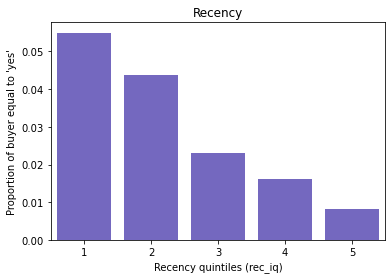

In [16]:
# insert code here
# recency
fig = rsm.prop_plot(train, "rec_iq", "buyer", "yes")
fig = fig.set(xlabel="Recency quintiles (rec_iq)", title='Recency')

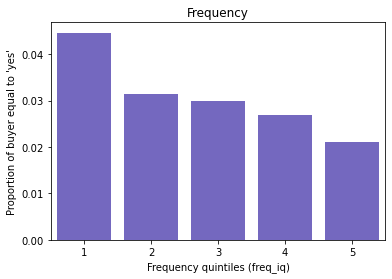

In [17]:
# frequency
fig = rsm.prop_plot(train, "freq_iq", "buyer", "yes")
fig = fig.set(xlabel="Frequency quintiles (freq_iq)", title='Frequency')

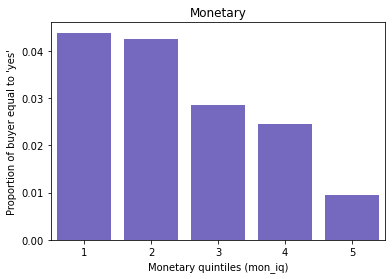

In [18]:
# monetary
fig = rsm.prop_plot(train, "mon_iq", "buyer", "yes")
fig = fig.set(xlabel="Monetary quintiles (mon_iq)", title='Monetary')

Group 1,which indicates the most active groups of users have a higher response rate as our expectation

### 5.	Could RFM predicts the ordersize?

In [19]:
## create a separate dataframe for convience
buy_yes = train.query("buyer=='yes'")

[Text(0.5, 0, 'Recency quintiles (rec_iq)'),
 Text(0, 0.5, 'Average Amount Spend (RMB)'),
 Text(0.5, 1.0, 'Revenue by Recency')]

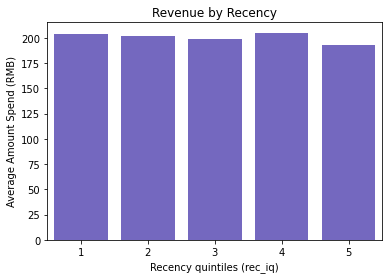

In [20]:
# insert code here
## Recency
df = buy_yes.groupby('rec_iq')['ordersize'].mean().to_frame().reset_index()
fig = sns.barplot(x='rec_iq',y='ordersize',data=df, color= "slateblue")
fig.set(xlabel="Recency quintiles (rec_iq)", ylabel="Average Amount Spend (RMB)", title="Revenue by Recency")

[Text(0.5, 0, 'Frequency quintiles (freq_iq)'),
 Text(0, 0.5, 'Average Amount Spend (RMB)'),
 Text(0.5, 1.0, 'Revenue by Frequency')]

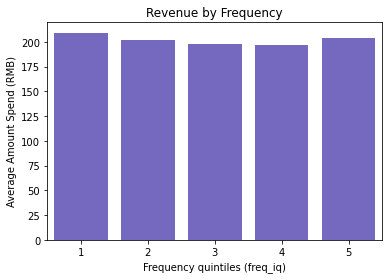

In [21]:
## Frequency
df = buy_yes.groupby('freq_iq')['ordersize'].mean().to_frame().reset_index()
fig = sns.barplot(x='freq_iq',y='ordersize',data=df, color= "slateblue")
fig.set(xlabel="Frequency quintiles (freq_iq)", ylabel="Average Amount Spend (RMB)", title="Revenue by Frequency")

[Text(0.5, 0, 'Monetary quintiles (mon_iq)'),
 Text(0, 0.5, 'Average Amount Spend (RMB)'),
 Text(0.5, 1.0, 'Revenue by Monetary')]

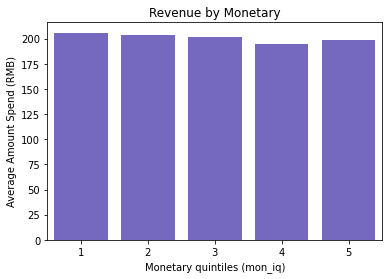

In [22]:
## Monetary
df = buy_yes.groupby('mon_iq')['ordersize'].mean().to_frame().reset_index()
fig = sns.barplot(x='mon_iq',y='ordersize',data=df, color= "slateblue")
fig.set(xlabel="Monetary quintiles (mon_iq)", ylabel="Average Amount Spend (RMB)", title="Revenue by Monetary")

The answer is no, we could clearly see that the ordersize doesn't change accordingly with the group number

## Part II: Profitability Analysis 

### 6.  The break-even response rate

In [23]:
cost = 2.5 
revenue = tuango[tuango['buyer']=='yes']['ordersize'].agg(np.nanmean)
margin =  revenue * 0.5 
breakeven =  cost/margin
breakeven

0.02473670736862159

The breakeven is 2.47%. The methodology behind the calculation is that we expect `response_rate * profit per person > cost`, so the response rate should be greater than cost/profit

### 7. What is the projected profit in RMB and the return on marketing expenditures if you offer the deal to all 250,902 remaining customers? (No Targeting)

In [24]:
# _nt stands for 'no targeting'

cost = 2.5
revenue = tuango[tuango['buyer']=='yes']['ordersize'].agg(np.nanmean)

nr_sms_nt = len(tuango.query('training==0')) # total number of SMSs that would be sent out
sms_cost_nt =  cost * nr_sms_nt # Total cost of sending sms messages to selected customers (float)
response_rate_nt = tuango['buyer_num'].agg(np.nanmean) # expressed as a proportion (no rounding)
nr_responses_nt =  response_rate_nt * nr_sms_nt # total number of positive responses

revenue_nt = nr_responses_nt * revenue  # total revenue in RMB (no rounding)
profit_nt = revenue_nt * 0.5 - sms_cost_nt  # total profit in RMB (no rounding)
ROME_nt = profit_nt/ sms_cost_nt# Return on Marketing Expenditures expressed as a proportion (no rounding)


print( f'nr_sms_nt:{nr_sms_nt}' )
print( f'sms_cost_nt:{sms_cost_nt}' )
print( f'nr_responses_nt:{nr_responses_nt}' )
print( f'response_rate_nt:{response_rate_nt}' )
print( f'revenue_nt:{revenue_nt}' )
print( f'profit_nt:{profit_nt}' )
print( f'ROME_nt:{ROME_nt}' )

nr_sms_nt:250902
sms_cost_nt:627255.0
nr_responses_nt:7479.0
response_rate_nt:0.02980845110840089
revenue_nt:1511721.0
profit_nt:128605.5
ROME_nt:0.20502905516895042


### 8. Evaluate the performance implications of offering the deal to only those customers (out of 250,902) in RFM cells with a response rate greater than the breakeven response rate

For RFM, we have independent quintile and sequential quintile, we will calculate the projected profit and ROME for both of them

In [25]:
# add `rfm_iq` to the tuango dataset
tuango['rfm_iq'] = tuango['rec_iq'].astype('str') + tuango['freq_iq'].astype('str') + tuango['mon_iq'].astype('str')

In [26]:
# Validaton 
print((tuango.rfm_iq_pre != tuango.rfm_iq).any()) # False : Pass
print((tuango.rfm_iq_pre == tuango.rfm_iq).sum()) # 278780 : Pass

False
278780


In [27]:
# determine which customers to sms based on independent quintiles RFM
tuango['rfm_iq_resp'] = tuango.groupby("rfm_iq")['buyer_num'].transform(np.nanmean)
tuango["smsto_iq"] = tuango['rfm_iq_resp'] > breakeven
# tuango

In [28]:
# insert calculation code to add columns `freq_sq`, and `mon_sq`
# to the `tuango` DataFrame
# Note that pandas `assign` method doesn't allow you to use variables created in the same call to assign

tuango['rec_sq'] = tuango['rec_iq']
tuango["freq_sq"] =tuango.groupby('rec_sq')['frequency'].transform(rsm.xtile,5,rev=True)
tuango["mon_sq"] =tuango.groupby(['rec_sq','freq_sq'])['monetary'].transform(rsm.xtile,5,rev=True)

In [29]:
# add `rfm_sq` to the tuango dataset
tuango["rfm_sq"] = tuango['rec_sq'].astype('str') + tuango['freq_sq'].astype('str') + tuango['mon_sq'].astype('str')

In [30]:
# determine which customers to sms based on sequential quintiles RFM
tuango['rfm_sq_resp'] = tuango.groupby("rfm_sq")['buyer_num'].transform(np.nanmean)
tuango["smsto_sq"] = tuango['rfm_sq_resp'] > breakeven
# tuango

In [31]:
tuango.groupby('training')[['smsto_iq','smsto_sq']].agg(np.nanmean)

,smsto_iq,smsto_sq
training,,
0,0.445018,0.403827
1,0.445441,0.405338


In [32]:
def perf_calc(dat=tuango, smsto=None, intro="", perf="buyer", lev="yes"):
    """
    Calculate projected performance implications from using different 
    targeting strategies

    Parameters
    ----------
    dat : Pandas DataFrame
        Pass the tuango dataset as the default value
    smsto : str
        A string with the name of the 'smsto' variable to use for calculations
    intro : str
        A string that provides an introduction to the printed output
    perf: str
        A string with the name of the performance variable to use ('buyer')
    lev: str
        A string with the name of the level in the perf variable that signifies success ('yes')

    Returns
    -------
    nr_sms : Total number of SMSs that would be sent out
    sms_cost : Total cost of sending sms messages to selected customers (float)
    nr_responses : Total number of positive responses
    response_rate : Expressed as a proportion (no rounding)
    revenue : Total revenue in RMB (no rounding)
    ROME : Return on Marketing Expenditures expressed as a proportion (no rounding)
    profit : Total profit in RMB (no rounding)
    """
    dat_train = dat.query("training == 1")
    dat_test = dat.query("training == 0")
    revenue_ep = dat_train[dat_train[perf]==lev]['ordersize'].agg(np.nanmean)  

    
    ## no targeting
    if smsto == None:
        nr_sms = len(dat_test)
        sms_cost = nr_sms * 2.5
        response_rate = (dat_train[perf]==lev).sum()/len(dat_train)


        
    else:
        nr_sms = (dat_test[smsto]).sum()
        sms_cost = nr_sms * 2.5
        response_rate = ((dat_train[perf]==lev) & (dat_train[smsto])).sum()/(dat_train[smsto]).sum()

    
    nr_responses = nr_sms * response_rate 
    revenue = nr_responses * revenue_ep
    profit = revenue * 0.5 - sms_cost
    ROME = profit/sms_cost
    
    print(intro)
    print( f'Total number of SMSs that would be sent out:{nr_sms:,.0f}' )
    print( f'Total cost of sending sms messages to selected customers:{sms_cost:,.0f}' )
    print( f'Total number of positive responses:{nr_responses:,.0f}' )
    print( f'Total percentage of positive responses:{100 * response_rate:.2f}%' )
    print( f'Total revenue in RMB :{revenue:,.0f}' )
    print( f'Total profit in RMB:{profit:,.0f}' )
    print( f'ROME:{100 * ROME:.2f}%' )

    return nr_sms, sms_cost, nr_responses, response_rate, revenue, ROME, profit

In [33]:
# calculate performance for no targeting
# _nt stands for 'no targeting'
nr_sms_nt, sms_cost_nt, nr_responses_nt, response_rate_nt, revenue_nt, ROME_nt, profit_nt = perf_calc(intro="If Tuango does not apply targeting")

If Tuango does not apply targeting
Total number of SMSs that would be sent out:250,902
Total cost of sending sms messages to selected customers:627,255
Total number of positive responses:7,479
Total percentage of positive responses:2.98%
Total revenue in RMB :1,511,721
Total profit in RMB:128,606
ROME:20.50%


In [34]:
# calculate performance for independent RFM
# _iq stands for 'independent quintiles'

nr_sms_iq, sms_cost_iq, nr_responses_iq, response_rate_iq, revenue_iq, ROME_iq, profit_iq = perf_calc(smsto = 'smsto_iq', intro="If Tuango apply independent RFM")

If Tuango apply independent RFM
Total number of SMSs that would be sent out:111,656
Total cost of sending sms messages to selected customers:279,140
Total number of positive responses:6,042
Total percentage of positive responses:5.41%
Total revenue in RMB :1,221,315
Total profit in RMB:331,518
ROME:118.76%


In [35]:
# calculate performance for sequential RFM
# _sq stands for 'sequential quintiles'

nr_sms_sq, sms_cost_sq, nr_responses_sq, response_rate_sq, revenue_sq, ROME_sq, profit_sq = perf_calc(smsto = 'smsto_sq', intro="If Tuango apply sequential RFM")

If Tuango apply sequential RFM
Total number of SMSs that would be sent out:101,321
Total cost of sending sms messages to selected customers:253,302
Total number of positive responses:5,837
Total percentage of positive responses:5.76%
Total revenue in RMB :1,179,859
Total profit in RMB:336,627
ROME:132.90%


### 9.Compare Independent and Sequential RFM method

In [36]:
# insert any calculation or plotting code here

## overlap
compare_overall = (tuango['rfm_iq']==tuango['rfm_sq']).agg(['count','sum']).to_frame().transpose()
compare_overall['perc'] = compare_overall['sum']/compare_overall['count']
compare_overall

,count,sum,perc
0,278780,175927,0.63106


1. Two approaches don't yield same RFM index for any given customers. There are about 63% overlap index between two methods, the rest 37% are different.
2. For independent method, same index is comparable in terms of each feature. For example, for customers with index 123 and 321, their frequency index means the same. However, as for the sequential method, only the recency score is comparable.
3. From a targeting perspective, sequential often perform (slightly) better on ROME (132.9% > 118.76%)

### 10.	 One step further: Use different breakeven for different RFM groups (Sequential as an example)


In [37]:
# calculate the average ordersize per sq code
tuango["avg_ordersize_sq"] = (tuango.groupby('rfm_sq')[['ordersize','buyer_num']]
                              .transform(np.nansum)
                              .apply(lambda x: x.ordersize/x.buyer_num,axis=1)
                              .fillna(0))

# calculate a breakeven value per sq code
tuango["breakeven_pc"] = (2.5/ (tuango["avg_ordersize_sq"] * 0.5)).replace(np.inf,breakeven)

# calculate the smsto variable based on breakeven value per sq code
# _pcsq stands for 'per cell sequential quintiles'

tuango["smsto_pcsq"] = tuango['rfm_sq_resp']>tuango['breakeven_pc']

/var/folders/t0/j235c8cd1kd0zm54j879h0t80000gn/T/ipykernel_6733/1690881786.py:4: RuntimeWarning: invalid value encountered in double_scalars
  .apply(lambda x: x.ordersize/x.buyer_num,axis=1)


In [38]:
# calculate performance for break-even-per-cell sequential RFM
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _pcsq stands for 'per cell sequential quintiles'

nr_sms_pcsq, sms_cost_pcsq, nr_responses_pcsq, response_rate_pcsq, revenue_pcsq, ROME_pcsq, profit_pcsq = perf_calc(
    dat=tuango,smsto="smsto_pcsq", intro="Based on sequential RFM with breakeven per cell"
)

Based on sequential RFM with breakeven per cell
Total number of SMSs that would be sent out:110,617
Total cost of sending sms messages to selected customers:276,542
Total number of positive responses:6,053
Total percentage of positive responses:5.47%
Total revenue in RMB :1,223,431
Total profit in RMB:335,173
ROME:121.20%


### 11.	One step further: One-side 95% confidence interval of the response rate for each RFM cell.

This could help us to limit risks in the long run, assuming each RFM cell use the same breakeven

In [39]:
# calculate the performance for lower bound with sequential quintiles
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _lbsq stands for 'lower bound with sequential quintiles'

def prop_lb(x):
    prop = np.nanmean(x) - 1.64 *rsm.seprop(x)
    return rsm.ifelse(prop<0,0,prop)

tuango['smsto_lbsq'] = tuango.groupby('rfm_sq').buyer_num.transform(prop_lb) > breakeven

In [40]:
nr_sms_lbsq, sms_cost_lbsq, nr_responses_lbsq, response_rate_lbsq, revenue_lbsq, ROME_lbsq, profit_lbsq = perf_calc(
    dat=tuango,
    smsto="smsto_lbsq",
    intro="Based on sequential RFM adjusted for response rate prediction accuracy"
)

Based on sequential RFM adjusted for response rate prediction accuracy
Total number of SMSs that would be sent out:54,974
Total cost of sending sms messages to selected customers:137,435
Total number of positive responses:4,083
Total percentage of positive responses:7.43%
Total revenue in RMB :825,378
Total profit in RMB:275,254
ROME:200.28%


In [41]:
# insert calculation code here - you do not need to do this 'per cell'
# _lbiq stands for 'lower bound independent quintiles'

def prop_lb(x):
    prop = np.nanmean(x) - 1.64 *rsm.seprop(x)
    return rsm.ifelse(prop<0,0,prop)

tuango['smsto_lbiq'] = tuango.groupby('rfm_iq').buyer_num.transform(prop_lb) > breakeven

In [42]:
# calculate the performance for lower bound with independent quintiles
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _lbiq stands for 'lower bound with independent quintiles'

nr_sms_lbiq, sms_cost_lbiq, nr_responses_lbiq, response_rate_lbiq, revenue_lbiq, ROME_lbiq, profit_lbiq = perf_calc(
    dat=tuango,
    smsto="smsto_lbiq",
    intro="Based on independent RFM adjusted for response rate prediction accuracy",
)

Based on independent RFM adjusted for response rate prediction accuracy
Total number of SMSs that would be sent out:54,445
Total cost of sending sms messages to selected customers:136,112
Total number of positive responses:4,116
Total percentage of positive responses:7.56%
Total revenue in RMB :831,998
Total profit in RMB:279,887
ROME:205.63%


### 12.	Compare the results

In [43]:
plot_data_pre = pd.DataFrame(
    {
        "name": [
            "No targeting",
            "Indep. RFM",
            "Seq. RFM",
            "Seq. PC RFM",
            "Seq. LB RFM",
            "Indep. LB RFM",
        ],
        "Profit": [
            profit_nt,
            profit_iq,
            profit_sq,
            profit_pcsq,
            profit_lbsq,
            profit_lbiq,
        ],
        "ROME": [ROME_nt, ROME_iq, ROME_sq, ROME_pcsq, ROME_lbsq, ROME_lbiq],
    }
)

In [44]:
sns.set(rc={'figure.figsize':(8,6)})

[Text(0, 0, '128606'),
 Text(0, 0, '331518'),
 Text(0, 0, '336627'),
 Text(0, 0, '335173'),
 Text(0, 0, '275254'),
 Text(0, 0, '279887')]

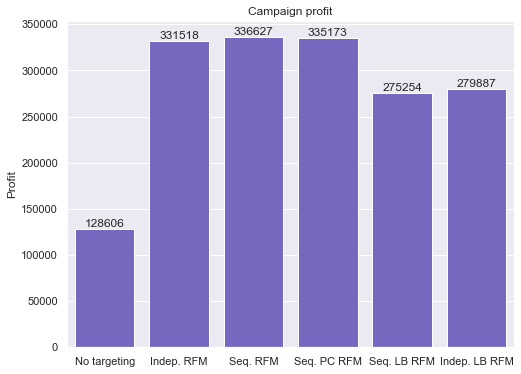

In [45]:
# insert code for the profit plot based on the 'plot_data' DataFrame

fig = sns.barplot(data = plot_data_pre,x='name',y='Profit',color="slateblue")
fig.set(xlabel="", ylabel="Profit", title="Campaign profit")
fig.bar_label(fig.containers[0])

[Text(0, 0, '0.205029'),
 Text(0, 0, '1.18764'),
 Text(0, 0, '1.32895'),
 Text(0, 0, '1.21201'),
 Text(0, 0, '2.00279'),
 Text(0, 0, '2.05629')]

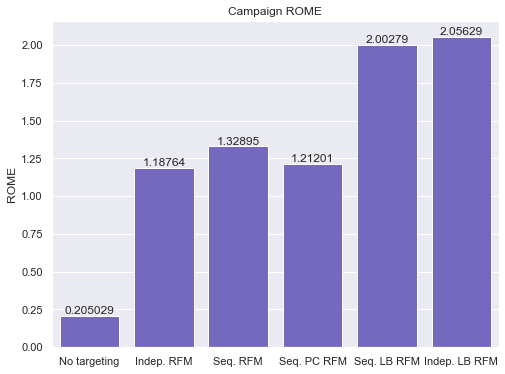

In [46]:
# insert code for the ROME plot based on the 'plot_data' DataFrame
fig = sns.barplot(data = plot_data_pre,x='name',y='ROME',color="slateblue")
fig.set(xlabel="", ylabel="ROME", title="Campaign ROME")
fig.bar_label(fig.containers[0])

- Based on our analysis, sequential RFM could generate the most profit followed by sequential RFM (using different breakeven) and independent RFM
- method considering confidence interval have a higher ROME and is useful when the company doesn't want to take risk.

## Part III: Post Experiment Validation

T company actually has all the response from customers, we could validate the actual performance for each method

In [47]:
post = pd.read_pickle("data/tuango_post.pkl")

In [48]:
tuango_post = tuango.copy()

In [49]:
tuango_post['buyer']=post['buyer']
tuango_post['ordersize']=post['ordersize']

In [50]:
def perf_calc_actual(dat=tuango_post, smsto=None, intro="", perf="buyer", lev="yes"):
    dat = dat[dat['training']==0]
    if smsto:
        perc_sms = np.mean(dat[smsto])
        dat=dat[dat[smsto]]
    else:
        perc_sms=1
    
    nr_sms = dat.shape[0]
    response_rate = np.mean(dat[perf]==lev)
    nr_responses = nr_sms * response_rate
    revenue = dat['ordersize'].sum()
    sms_cost = 2.5*nr_sms
    profit = revenue * 0.5 - sms_cost
    ROME = profit/sms_cost
    
    print(intro)
    print( f'The number of customers Tcompany should SMS is:{nr_sms:,.0f}' )
    print( f'Total cost of sending sms messages to selected customers:{sms_cost:,.0f}' )
    print( f'Total number of positive responses:{nr_responses:,.0f}' )
    print( f'Total percentage of positive responses:{100 * response_rate:.2f}%' )
    print( f'Total revenue in RMB :{revenue:,.2f}' )
    print( f'Total profit in RMB:{profit:,.0f}' )
    print( f'ROME:{100 * ROME:.2f}%' )

    return nr_sms, sms_cost, nr_responses, response_rate, revenue, ROME, profit
    

In [51]:
nr_sms_nt, sms_cost_nt, nr_responses_nt, response_rate_nt, revenue_nt, ROME_nt, profit_nt = perf_calc_actual(intro="If Tuango does not apply targeting")

If Tuango does not apply targeting
The number of customers Tcompany should SMS is:250,902
Total cost of sending sms messages to selected customers:627,255
Total number of positive responses:7,425
Total percentage of positive responses:2.96%
Total revenue in RMB :1,503,495.00
Total profit in RMB:124,492
ROME:19.85%


In [52]:
nr_sms_iq, sms_cost_iq, nr_responses_iq, response_rate_iq, revenue_iq, ROME_iq, profit_iq = perf_calc_actual(smsto = 'smsto_iq', intro="If Tuango apply independent RFM")

If Tuango apply independent RFM
The number of customers Tcompany should SMS is:111,656
Total cost of sending sms messages to selected customers:279,140
Total number of positive responses:6,018
Total percentage of positive responses:5.39%
Total revenue in RMB :1,219,552.00
Total profit in RMB:330,636
ROME:118.45%


In [53]:
nr_sms_sq, sms_cost_sq, nr_responses_sq, response_rate_sq, revenue_sq, ROME_sq, profit_sq = perf_calc_actual( smsto = 'smsto_sq', intro="If Tuango apply sequential RFM")

If Tuango apply sequential RFM
The number of customers Tcompany should SMS is:101,321
Total cost of sending sms messages to selected customers:253,302
Total number of positive responses:5,821
Total percentage of positive responses:5.75%
Total revenue in RMB :1,189,499.00
Total profit in RMB:341,447
ROME:134.80%


In [54]:
nr_sms_pcsq, sms_cost_pcsq, nr_responses_pcsq, response_rate_pcsq, revenue_pcsq, ROME_pcsq, profit_pcsq = perf_calc_actual(
    smsto="smsto_pcsq", intro="Based on sequential RFM with breakeven per cell"
)

Based on sequential RFM with breakeven per cell
The number of customers Tcompany should SMS is:110,617
Total cost of sending sms messages to selected customers:276,542
Total number of positive responses:6,022
Total percentage of positive responses:5.44%
Total revenue in RMB :1,234,808.00
Total profit in RMB:340,862
ROME:123.26%


In [55]:
nr_sms_lbsq, sms_cost_lbsq, nr_responses_lbsq, response_rate_lbsq, revenue_lbsq, ROME_lbsq, profit_lbsq = perf_calc_actual(
    smsto="smsto_lbsq",
    intro="Based on sequential RFM adjusted for response rate prediction accuracy",
)

Based on sequential RFM adjusted for response rate prediction accuracy
The number of customers Tcompany should SMS is:54,974
Total cost of sending sms messages to selected customers:137,435
Total number of positive responses:4,069
Total percentage of positive responses:7.40%
Total revenue in RMB :838,801.00
Total profit in RMB:281,966
ROME:205.16%


In [56]:
nr_sms_lbiq, sms_cost_lbiq, nr_responses_lbiq, response_rate_lbiq, revenue_lbiq, ROME_lbiq, profit_lbiq = perf_calc_actual(
    smsto="smsto_lbiq",
    intro="Based on independent RFM adjusted for response rate prediction accuracy",
)

Based on independent RFM adjusted for response rate prediction accuracy
The number of customers Tcompany should SMS is:54,445
Total cost of sending sms messages to selected customers:136,112
Total number of positive responses:4,099
Total percentage of positive responses:7.53%
Total revenue in RMB :844,111.00
Total profit in RMB:285,943
ROME:210.08%


In [57]:
plot_data_post = pd.DataFrame(
    {
        "name": [
            "No targeting",
            "Indep. RFM",
            "Seq. RFM",
            "Seq. PC RFM",
            "Seq. LB RFM",
            "Indep. LB RFM",
        ],
        "Profit": [
            profit_nt,
            profit_iq,
            profit_sq,
            profit_pcsq,
            profit_lbsq,
            profit_lbiq,
        ],
        "ROME": [ROME_nt, ROME_iq, ROME_sq, ROME_pcsq, ROME_lbsq, ROME_lbiq],
    }
)

[Text(0, 0, '124492'),
 Text(0, 0, '330636'),
 Text(0, 0, '341447'),
 Text(0, 0, '340862'),
 Text(0, 0, '281966'),
 Text(0, 0, '285943')]

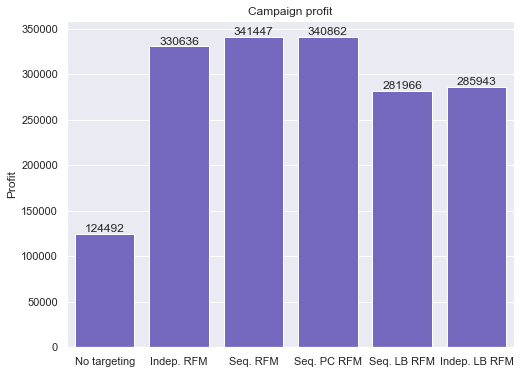

In [58]:
# insert code for the profit plot based on the 'plot_data' DataFrame

fig = sns.barplot(data = plot_data_post,x='name',y='Profit',color="slateblue")
fig.set(xlabel="", ylabel="Profit", title="Campaign profit")
fig.bar_label(fig.containers[0])

[Text(0, 0, '0.198472'),
 Text(0, 0, '1.18448'),
 Text(0, 0, '1.34798'),
 Text(0, 0, '1.23258'),
 Text(0, 0, '2.05163'),
 Text(0, 0, '2.10078')]

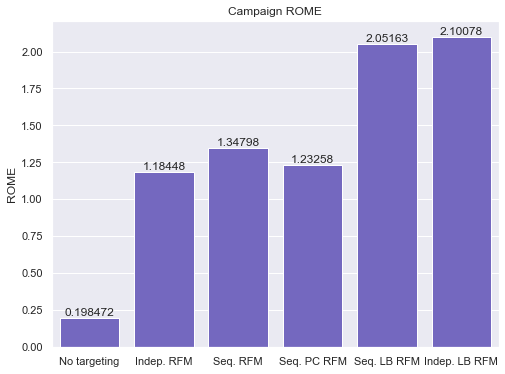

In [59]:
# insert code for the ROME plot based on the 'plot_data' DataFrame
fig = sns.barplot(data = plot_data_post,x='name',y='ROME',color="slateblue")
fig.set(xlabel="", ylabel="ROME", title="Campaign ROME")
fig.bar_label(fig.containers[0])

In [60]:
plot_data_pre['type']='pre'
plot_data_post['type']='post'

In [61]:
plot_data_all = pd.concat([plot_data_pre,plot_data_post])

In [62]:
sns.set(rc={'figure.figsize':(16,6)})

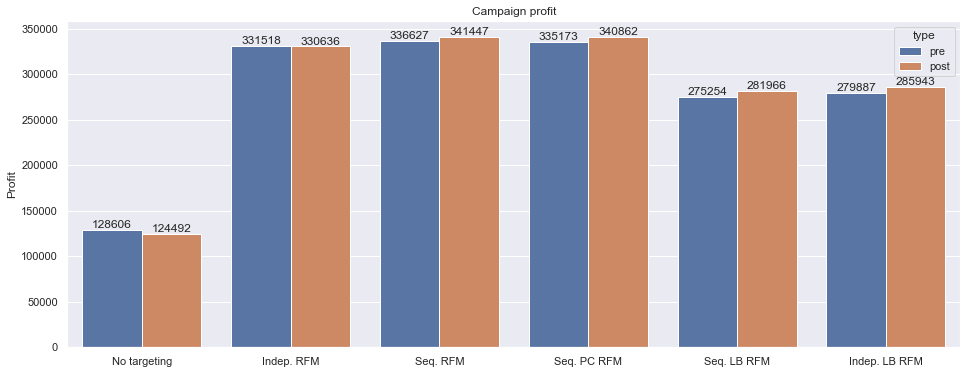

In [63]:
fig = sns.barplot(data = plot_data_all,x='name',y='Profit',hue='type')
fig.set(xlabel="", ylabel="Profit", title="Campaign profit")
for container in fig.containers:
    fig.bar_label(container)

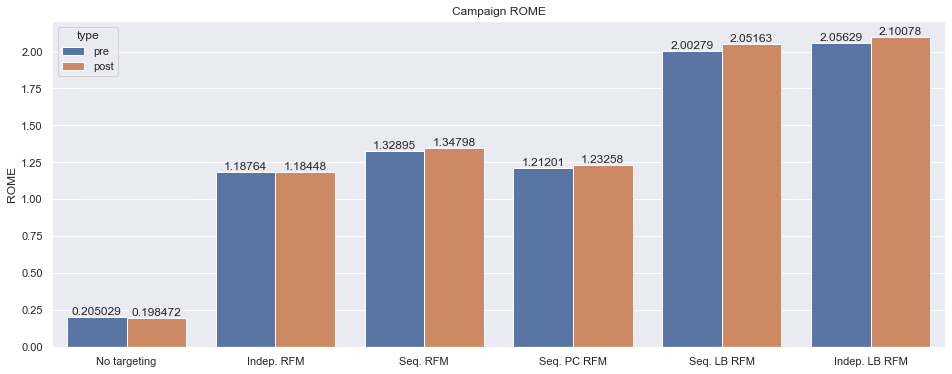

In [64]:
fig = sns.barplot(data = plot_data_all,x='name',y='ROME',hue='type')
fig.set(xlabel="", ylabel="ROME", title="Campaign ROME")
for container in fig.containers:
    fig.bar_label(container)

We can see from the comparasion that RFM targeting analysis works well.